In [3]:
#1. Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from bs4 import BeautifulSoup
import re, string, unicodedata
!pip install contractions
import contractions


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 327kB 7.8MB/s 
     |████████████████████████████████| 245kB 13.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84334 sha256=f69b35d8bc14d901267d140f092553666de657954f61cebc9eb54fa400eb21b6
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#1. Load dataset
tweets = pd.read_csv('/content/drive/MyDrive/NL/project/Tweets.csv')

In [7]:
# 1. print shape
print(tweets.shape)
print(tweets.columns)

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [8]:
tweets.describe()
# description of numeric columns

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
tweets.head()
# data is tweets about  airlines 

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
# 2. drop all colums except text , airline_sentiment
# airline_sentiment is the target(dependent variable) and text is the tweet that needs to be analyzed 

df = tweets[['text','airline_sentiment']]

In [11]:
# 2. print head
print(df.shape)
pd.set_option('display.max_colwidth',None)
print(df.head(20))

(14640, 2)
                                                                                                                                            text airline_sentiment
0                                                                                                            @VirginAmerica What @dhepburn said.           neutral
1                                                                       @VirginAmerica plus you've added commercials to the experience... tacky.          positive
2                                                                        @VirginAmerica I didn't today... Must mean I need to take another trip!           neutral
3                 @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse          negative
4                                                                                        @VirginAmerica and it's a really big bad thing about it          negative
5       @Vi

In [12]:

df['airline_sentiment'].value_counts()
# there are 3 different sentiment classes negative, neutral, and positive-

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [13]:
df['airline_sentiment'].value_counts(normalize =True)
# 62% negative comments and just 16% positive

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [14]:
# there are special (unicode)characters, contractions ...
# 3.a remove html tags
def strip_htmltags(line):
  soup = BeautifulSoup(line)
  return contractions.fix(soup.get_text())

strip_htmltags(df.at[0,'text'])

'@VirginAmerica What @dhepburn said.'

In [15]:
#3. b tokenize
def tokenize(line):
  words = nltk.word_tokenize(line)
  return words
words = tokenize(strip_htmltags(df.at[0,'text']))
print(words)

['@', 'VirginAmerica', 'What', '@', 'dhepburn', 'said', '.']


In [16]:
#3.c remove numbers
def remove_numbers(words):
  new_words = []
  for word in words:
    new_word = re.sub(r'[0-9]','',word)
    if(len(new_word) > 0):
      new_words.append(new_word)
  return new_words
arr = ['123abc','abc','df45h','$89']
print(remove_numbers(arr))      


['abc', 'abc', 'dfh', '$']


In [17]:
#3.d
def remove_specialchar(words):
  word_arr = []
  for word in words:
    newword= unicodedata.normalize('NFKD',word).encode('ascii','ignore').decode('utf-8','ignore')
    if len(newword) > 0:
      word_arr.append(newword)
  return word_arr   
sp_text = 'I ❤️ flying @VirginAmerica. ☺️👍'
wordss = remove_specialchar(tokenize(sp_text))
print (wordss)

['I', 'flying', '@', 'VirginAmerica', '.']


In [18]:
# 3.d,e removing puctuation
def remove_punctuation(words):
  new_words=[]
  for word in words:
    new_word = re.sub(r'[^\w\s]','',word)
    if len(new_word) > 0:
      new_words.append(new_word.lower()) 
  return new_words;  

tokens =  remove_punctuation(wordss)
print(tokens)


['i', 'flying', 'virginamerica']


In [19]:
# 3.f lemmatize the words 
nltk.download('wordnet')
def lemmatizewords(words):
  newwords =[]
  lemmatizer = WordNetLemmatizer()
  for word in words:
    newwords.append(lemmatizer.lemmatize(word,pos='v'))
  return newwords  
print(lemmatizewords(tokens))  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['i', 'fly', 'virginamerica']


In [20]:
# remove stop words
stop_words = set(stopwords.words('english'))
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# remove the custom stop words        
stop = stop_words -set(customlist)        
tweets_count = df['text'].size
# Do  all the above prprocessing  and construct pandas dataframe as each row contains word of a line
def preprocess_text(line):
    # remove html tags and replace contractions
    html_stripped_line = strip_htmltags(line)
    # split the line into words
    words = tokenize(html_stripped_line)
    # remove_numbers
    words = remove_numbers(words)
    # remove non ascii
    words = remove_specialchar(words)
    # remove punctuation and convert to lower case
    words = remove_punctuation(words)
   
    # remove stop words
    words = [w for w in words if  not w in stop]
    # lemmatize the words
    lemmatized = lemmatizewords(words)
    # join the words back
    return ' '.join(lemmatized)
    
df['text'] = df.apply(lambda row:  preprocess_text(row['text']), axis =1)    


df.tail(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,airline_sentiment
14635,americanair thank get different flight chicago,positive
14636,americanair leave minutes late flight warn communication minutes late flight call shitty customer svc,negative
14637,americanair please bring american airlines blackberry,neutral
14638,americanair money change flight not answer phone suggestions make commitment,negative
14639,americanair ppl need know many seat next flight plz put us standby people next flight,neutral


In [21]:
# print  first 5 lines after preprocessing
df.head(5)

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience tacky,positive
2,virginamerica not today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,negative
4,virginamerica really big bad thing,negative


In [22]:
# 4. Vectorization Get only 1000 prioratized words (use count vectorizer first)
vectorizer = CountVectorizer(max_features=1000)
features = vectorizer.fit_transform(df['text'])

In [23]:
# convert  features to array to feed into ML mode
X= features.toarray()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer
enc= LabelBinarizer()
Y = enc.fit_transform(df['airline_sentiment'])
Y.shape
for i in range(0,5):
  print(Y[i])
print (enc.inverse_transform(Y))
# there are 3 classes

[0 1 0]
[0 0 1]
[0 1 0]
[1 0 0]
[1 0 0]
['neutral' 'positive' 'neutral' ... 'neutral' 'negative' 'neutral']


In [24]:
Y = Y.astype(int)

In [25]:
Y.shape
Y[0]

array([0, 1, 0])

In [26]:

# split train and test data
x_train, x_test, y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state = 45)

In [27]:

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11712, 1000)
(2928, 1000)
(11712, 3)
(2928, 3)


In [28]:
#5. build model using RandomForestClassifier(count vectorizer)
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(x_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, X, Y, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6477459016393443


In [29]:
# Predict the result for test data using the model built above.

predict = forest.predict(x_test)

In [30]:
from sklearn.metrics import classification_report
print(predict[0])
print(y_test[0])
# convert one hot encoding to class index 

y_true =np.argmax(y_test,axis=1) 

result = np.argmax(predict,axis=1)
# print classification report
print(classification_report(y_true, result))

[1 0 0]
[1 0 0]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1832
           1       0.57      0.41      0.48       623
           2       0.75      0.50      0.60       473

    accuracy                           0.74      2928
   macro avg       0.70      0.61      0.64      2928
weighted avg       0.72      0.74      0.72      2928



[[1668  129   35]
 [ 327  253   43]
 [ 177   60  236]]


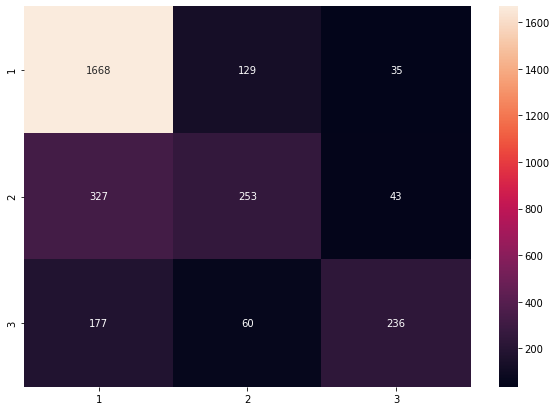

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, result)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [38]:
#vectorization using TfidfVectorizer
tfidVectorizer = TfidfVectorizer(max_features =1000)
features = tfidVectorizer.fit_transform(df['text'])

In [39]:
# convert  features to array to feed into ML mode
X= features.toarray()

# split train and test data
x_train, x_test, y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state = 45)

In [40]:
# 5. build model using RabdomForestClassifier (TfidfVectorizer features)
forest_tfid = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest_tfid = forest_tfid.fit(x_train, y_train)

print(forest_tfid)

print(np.mean(cross_val_score(forest_tfid, X, Y, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6741120218579235


In [41]:
# Predict the result for test data using the model built above.

predict = forest_tfid.predict(x_test)

In [42]:
from sklearn.metrics import classification_report
print(predict[0])
print(y_test[0])
# convert one hot encoding to class index 

y_true = np.argmax(y_test,axis=1) 

result = np.argmax(predict,axis=1)
# print classification report
print(classification_report(y_true, result))

[1 0 0]
[1 0 0]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1832
           1       0.64      0.35      0.46       623
           2       0.81      0.44      0.57       473

    accuracy                           0.74      2928
   macro avg       0.73      0.58      0.62      2928
weighted avg       0.74      0.74      0.72      2928



[[1745   70   17]
 [ 370  221   32]
 [ 209   54  210]]


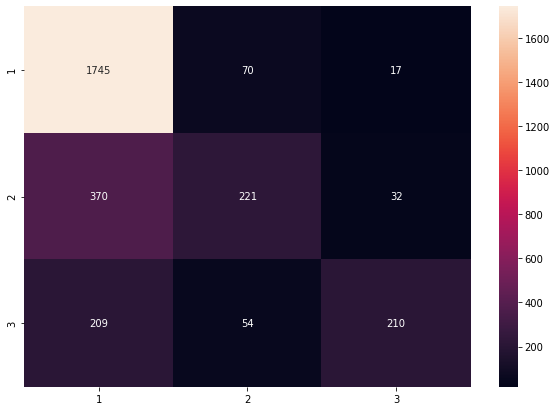

In [43]:
cm = confusion_matrix(y_true, result)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Summary


Preprocessing:
- Used html tag removal, contractions expanded, tokenized the words 
- removed all the meaningless stop words
- remove numbers using regex
- removed special characters, emojis 
- lemmatized the words instead of stemming,because the words are valid ones  present in dictionary

Vectorization:
  -Did Count Vectorization first and fetched 1000 hige priority words (in this case words which have high frequency in each doc.)
  - accuracy is not bad (64%)
  - recall score of (negative sentiment is also high)


Tried TfidfVectrozer again
 - accuracy is better (67%)
 - because features are prioritized using TF-IDF whick evaluates the find the words(features) based on  all the documents not just individual document.
  